## Graph Neural Networks

We now use Tensorflow to classify nodes in a graph using Graph Convolution Networks.

First, install gcn on your machine using the 'python setup.py install' command.

# Exercise for semisupervised classification on citation networks

In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

In [2]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [3]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#--------------- Your code here --------------#
# masked_mean_square_error(preds,labels,mask)


#--------------------------------------------#

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [4]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [5]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)


In [6]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [7]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95399 train_acc= 0.07143 val_loss= 1.95070 val_acc= 0.20600 time= 0.04418
Epoch: 0002 train_loss= 1.94801 train_acc= 0.29286 val_loss= 1.94716 val_acc= 0.37000 time= 0.01785
Epoch: 0003 train_loss= 1.94218 train_acc= 0.48571 val_loss= 1.94333 val_acc= 0.47000 time= 0.01654
Epoch: 0004 train_loss= 1.93654 train_acc= 0.56429 val_loss= 1.93922 val_acc= 0.50400 time= 0.01642
Epoch: 0005 train_loss= 1.92665 train_acc= 0.66429 val_loss= 1.93517 val_acc= 0.50400 time= 0.01668
Epoch: 0006 train_loss= 1.92017 train_acc= 0.70000 val_loss= 1.93110 val_acc= 0.51400 time= 0.01589
Epoch: 0007 train_loss= 1.91050 train_acc= 0.71429 val_loss= 1.92704 val_acc= 0.52000 time= 0.01521
Epoch: 0008 train_loss= 1.89941 train_acc= 0.71429 val_loss= 1.92310 val_acc= 0.51600 time= 0.01671
Epoch: 0009 train_loss= 1.89015 train_acc= 0.75714 val_loss= 1.91920 val_acc= 0.52000 time= 0.01663
Epoch: 0010 train_loss= 1.88369 train_acc= 0.67143 val_loss= 1.91527 val_acc= 0.52000 time= 0.01711


Epoch: 0089 train_loss= 0.97455 train_acc= 0.91429 val_loss= 1.33826 val_acc= 0.78000 time= 0.01662
Epoch: 0090 train_loss= 0.97957 train_acc= 0.91429 val_loss= 1.33204 val_acc= 0.78000 time= 0.02215
Epoch: 0091 train_loss= 0.92480 train_acc= 0.95000 val_loss= 1.32596 val_acc= 0.78000 time= 0.01707
Epoch: 0092 train_loss= 0.95817 train_acc= 0.92143 val_loss= 1.32011 val_acc= 0.78000 time= 0.01651
Epoch: 0093 train_loss= 0.89500 train_acc= 0.95000 val_loss= 1.31456 val_acc= 0.77800 time= 0.01727
Epoch: 0094 train_loss= 0.86474 train_acc= 0.92857 val_loss= 1.30937 val_acc= 0.77800 time= 0.01606
Epoch: 0095 train_loss= 0.90715 train_acc= 0.96429 val_loss= 1.30445 val_acc= 0.78000 time= 0.01738
Epoch: 0096 train_loss= 0.89772 train_acc= 0.93571 val_loss= 1.29963 val_acc= 0.78000 time= 0.01695
Epoch: 0097 train_loss= 0.88455 train_acc= 0.93571 val_loss= 1.29490 val_acc= 0.78000 time= 0.01762
Epoch: 0098 train_loss= 0.93267 train_acc= 0.91429 val_loss= 1.29068 val_acc= 0.78000 time= 0.01813


Epoch: 0174 train_loss= 0.58342 train_acc= 0.98571 val_loss= 1.09138 val_acc= 0.77800 time= 0.01795
Epoch: 0175 train_loss= 0.67515 train_acc= 0.94286 val_loss= 1.08887 val_acc= 0.77400 time= 0.01686
Epoch: 0176 train_loss= 0.68394 train_acc= 0.93571 val_loss= 1.08582 val_acc= 0.77800 time= 0.02014
Epoch: 0177 train_loss= 0.70085 train_acc= 0.94286 val_loss= 1.08304 val_acc= 0.77800 time= 0.01534
Epoch: 0178 train_loss= 0.60540 train_acc= 0.98571 val_loss= 1.08044 val_acc= 0.77800 time= 0.01641
Epoch: 0179 train_loss= 0.63127 train_acc= 0.95000 val_loss= 1.07856 val_acc= 0.78200 time= 0.01525
Epoch: 0180 train_loss= 0.69479 train_acc= 0.93571 val_loss= 1.07661 val_acc= 0.78200 time= 0.01535
Epoch: 0181 train_loss= 0.62900 train_acc= 0.97857 val_loss= 1.07482 val_acc= 0.78600 time= 0.01476
Epoch: 0182 train_loss= 0.64596 train_acc= 0.92857 val_loss= 1.07334 val_acc= 0.78600 time= 0.01779
Epoch: 0183 train_loss= 0.59649 train_acc= 0.97857 val_loss= 1.07162 val_acc= 0.78400 time= 0.01688


In [8]:
# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 1.01263 accuracy= 0.81400 time= 0.01046


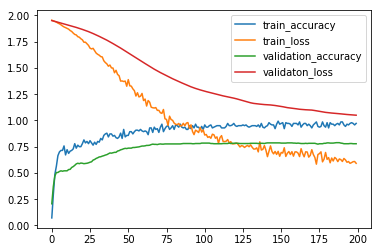

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.show()

# 1. With no weight decay / dropout  (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **without weight decay and without dropout**.

In [16]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += var # no decay

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=False,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=False,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [17]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    # feed_dict.update({placeholders['dropout']: FLAGS.dropout}) no dropout

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95414 train_acc= 0.10000 val_loss= 1.95027 val_acc= 0.26200 time= 0.04285
Epoch: 0002 train_loss= 1.94582 train_acc= 0.53571 val_loss= 1.94642 val_acc= 0.38200 time= 0.02944
Epoch: 0003 train_loss= 1.93747 train_acc= 0.67857 val_loss= 1.94275 val_acc= 0.38800 time= 0.02113
Epoch: 0004 train_loss= 1.92843 train_acc= 0.69286 val_loss= 1.93952 val_acc= 0.36600 time= 0.02728
Epoch: 0005 train_loss= 1.91928 train_acc= 0.70714 val_loss= 1.93660 val_acc= 0.35400 time= 0.04375
Epoch: 0006 train_loss= 1.91002 train_acc= 0.75714 val_loss= 1.93373 val_acc= 0.36600 time= 0.03401
Epoch: 0007 train_loss= 1.90043 train_acc= 0.76429 val_loss= 1.93093 val_acc= 0.39600 time= 0.02245
Epoch: 0008 train_loss= 1.89058 train_acc= 0.78571 val_loss= 1.92824 val_acc= 0.42400 time= 0.01904
Epoch: 0009 train_loss= 1.88050 train_acc= 0.81429 val_loss= 1.92563 val_acc= 0.43400 time= 0.02283
Epoch: 0010 train_loss= 1.87018 train_acc= 0.82143 val_loss= 1.92305 val_acc= 0.44600 time= 0.02466


Epoch: 0087 train_loss= 0.85029 train_acc= 0.98571 val_loss= 1.42330 val_acc= 0.76000 time= 0.01951
Epoch: 0088 train_loss= 0.84267 train_acc= 0.98571 val_loss= 1.41696 val_acc= 0.76200 time= 0.02332
Epoch: 0089 train_loss= 0.83522 train_acc= 0.98571 val_loss= 1.41078 val_acc= 0.76200 time= 0.02134
Epoch: 0090 train_loss= 0.82793 train_acc= 0.98571 val_loss= 1.40453 val_acc= 0.76200 time= 0.01940
Epoch: 0091 train_loss= 0.82080 train_acc= 0.98571 val_loss= 1.39833 val_acc= 0.76600 time= 0.01984
Epoch: 0092 train_loss= 0.81382 train_acc= 0.98571 val_loss= 1.39236 val_acc= 0.77000 time= 0.01802
Epoch: 0093 train_loss= 0.80699 train_acc= 0.98571 val_loss= 1.38658 val_acc= 0.77000 time= 0.01902
Epoch: 0094 train_loss= 0.80030 train_acc= 0.98571 val_loss= 1.38089 val_acc= 0.77000 time= 0.01845
Epoch: 0095 train_loss= 0.79377 train_acc= 0.98571 val_loss= 1.37517 val_acc= 0.77000 time= 0.01829
Epoch: 0096 train_loss= 0.78736 train_acc= 0.98571 val_loss= 1.36963 val_acc= 0.76800 time= 0.01868


Epoch: 0177 train_loss= 0.51084 train_acc= 1.00000 val_loss= 1.11587 val_acc= 0.78600 time= 0.02122
Epoch: 0178 train_loss= 0.50897 train_acc= 1.00000 val_loss= 1.11413 val_acc= 0.78600 time= 0.02158
Epoch: 0179 train_loss= 0.50711 train_acc= 1.00000 val_loss= 1.11222 val_acc= 0.78600 time= 0.02433
Epoch: 0180 train_loss= 0.50527 train_acc= 1.00000 val_loss= 1.11038 val_acc= 0.78600 time= 0.02255
Epoch: 0181 train_loss= 0.50345 train_acc= 1.00000 val_loss= 1.10862 val_acc= 0.78800 time= 0.01984
Epoch: 0182 train_loss= 0.50165 train_acc= 1.00000 val_loss= 1.10686 val_acc= 0.78800 time= 0.02121
Epoch: 0183 train_loss= 0.49987 train_acc= 1.00000 val_loss= 1.10509 val_acc= 0.78600 time= 0.02003
Epoch: 0184 train_loss= 0.49810 train_acc= 1.00000 val_loss= 1.10348 val_acc= 0.78600 time= 0.02063
Epoch: 0185 train_loss= 0.49635 train_acc= 1.00000 val_loss= 1.10198 val_acc= 0.78600 time= 0.02199
Epoch: 0186 train_loss= 0.49462 train_acc= 1.00000 val_loss= 1.10026 val_acc= 0.78400 time= 0.02174


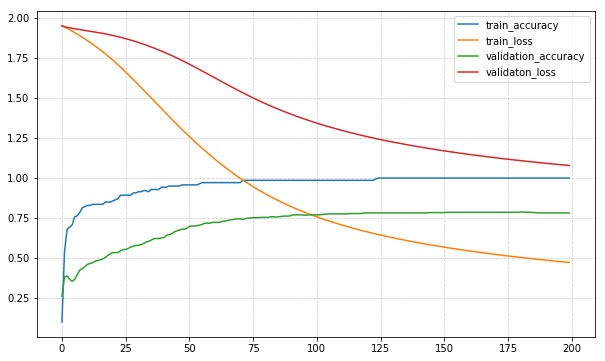

In [18]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 2. Change it to $A^2$ (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **after changing the adjacency matrix to $A^2$ **.

In [19]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)
    
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_square = normalize_adj(np.power(adj, 2).tocoo())
    
    return sparse_to_tuple(adj_square)



In [20]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95314 train_acc= 0.17143 val_loss= 1.94934 val_acc= 0.35800 time= 0.02111
Epoch: 0002 train_loss= 1.94701 train_acc= 0.43571 val_loss= 1.94535 val_acc= 0.42000 time= 0.01579
Epoch: 0003 train_loss= 1.93991 train_acc= 0.55000 val_loss= 1.94098 val_acc= 0.50000 time= 0.01518
Epoch: 0004 train_loss= 1.93230 train_acc= 0.61429 val_loss= 1.93619 val_acc= 0.59000 time= 0.01560
Epoch: 0005 train_loss= 1.92234 train_acc= 0.74286 val_loss= 1.93139 val_acc= 0.63800 time= 0.01592
Epoch: 0006 train_loss= 1.91620 train_acc= 0.75000 val_loss= 1.92684 val_acc= 0.66400 time= 0.01515
Epoch: 0007 train_loss= 1.90641 train_acc= 0.79286 val_loss= 1.92259 val_acc= 0.66800 time= 0.01585
Epoch: 0008 train_loss= 1.90064 train_acc= 0.77857 val_loss= 1.91856 val_acc= 0.67400 time= 0.01531
Epoch: 0009 train_loss= 1.89145 train_acc= 0.80714 val_loss= 1.91453 val_acc= 0.67200 time= 0.01492
Epoch: 0010 train_loss= 1.88057 train_acc= 0.80000 val_loss= 1.91033 val_acc= 0.68000 time= 0.01499


Epoch: 0092 train_loss= 0.94842 train_acc= 0.91429 val_loss= 1.36416 val_acc= 0.79800 time= 0.01629
Epoch: 0093 train_loss= 0.94799 train_acc= 0.93571 val_loss= 1.35984 val_acc= 0.79800 time= 0.01788
Epoch: 0094 train_loss= 0.95595 train_acc= 0.90000 val_loss= 1.35540 val_acc= 0.79800 time= 0.02216
Epoch: 0095 train_loss= 0.94299 train_acc= 0.93571 val_loss= 1.35056 val_acc= 0.79800 time= 0.01634
Epoch: 0096 train_loss= 0.94064 train_acc= 0.92857 val_loss= 1.34548 val_acc= 0.79800 time= 0.01654
Epoch: 0097 train_loss= 0.90469 train_acc= 0.94286 val_loss= 1.34019 val_acc= 0.79800 time= 0.01470
Epoch: 0098 train_loss= 0.87104 train_acc= 0.95714 val_loss= 1.33474 val_acc= 0.79600 time= 0.01456
Epoch: 0099 train_loss= 0.89257 train_acc= 0.91429 val_loss= 1.32918 val_acc= 0.79800 time= 0.01516
Epoch: 0100 train_loss= 0.88534 train_acc= 0.94286 val_loss= 1.32377 val_acc= 0.79600 time= 0.01550
Epoch: 0101 train_loss= 0.90665 train_acc= 0.92143 val_loss= 1.31876 val_acc= 0.79600 time= 0.01448


Epoch: 0175 train_loss= 0.63393 train_acc= 0.96429 val_loss= 1.10263 val_acc= 0.79200 time= 0.01760
Epoch: 0176 train_loss= 0.66327 train_acc= 0.97857 val_loss= 1.10071 val_acc= 0.79400 time= 0.02034
Epoch: 0177 train_loss= 0.61990 train_acc= 0.96429 val_loss= 1.09859 val_acc= 0.79200 time= 0.01651
Epoch: 0178 train_loss= 0.65620 train_acc= 0.93571 val_loss= 1.09621 val_acc= 0.79200 time= 0.01522
Epoch: 0179 train_loss= 0.65587 train_acc= 0.95714 val_loss= 1.09428 val_acc= 0.79200 time= 0.01536
Epoch: 0180 train_loss= 0.70108 train_acc= 0.93571 val_loss= 1.09381 val_acc= 0.79200 time= 0.01560
Epoch: 0181 train_loss= 0.61087 train_acc= 0.95714 val_loss= 1.09376 val_acc= 0.79200 time= 0.01548
Epoch: 0182 train_loss= 0.61427 train_acc= 0.96429 val_loss= 1.09344 val_acc= 0.79400 time= 0.01517
Epoch: 0183 train_loss= 0.60254 train_acc= 0.95000 val_loss= 1.09315 val_acc= 0.79200 time= 0.01602
Epoch: 0184 train_loss= 0.61065 train_acc= 0.97143 val_loss= 1.09255 val_acc= 0.79200 time= 0.01529


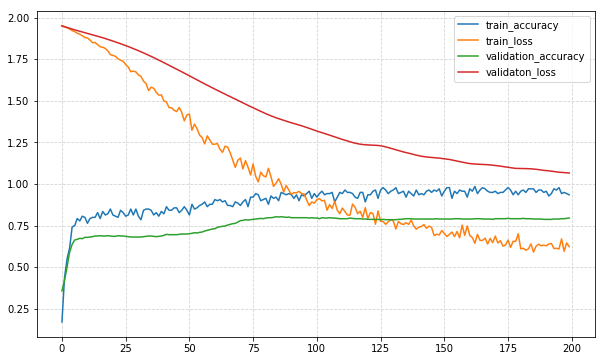

In [21]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 3. Change to the $L_2$ loss

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **with the loss function being $L_2$ loss**.

In [23]:
#--------------- Your code here --------------#
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

#--------------------------------------------#

In [24]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95353 train_acc= 0.23571 val_loss= 1.94960 val_acc= 0.31200 time= 0.02304
Epoch: 0002 train_loss= 1.94768 train_acc= 0.37857 val_loss= 1.94578 val_acc= 0.43600 time= 0.01640
Epoch: 0003 train_loss= 1.94132 train_acc= 0.59286 val_loss= 1.94137 val_acc= 0.53600 time= 0.01625
Epoch: 0004 train_loss= 1.93332 train_acc= 0.65714 val_loss= 1.93634 val_acc= 0.63600 time= 0.01530
Epoch: 0005 train_loss= 1.92615 train_acc= 0.74286 val_loss= 1.93132 val_acc= 0.68200 time= 0.01516
Epoch: 0006 train_loss= 1.92024 train_acc= 0.73571 val_loss= 1.92657 val_acc= 0.68600 time= 0.01599
Epoch: 0007 train_loss= 1.91059 train_acc= 0.75714 val_loss= 1.92203 val_acc= 0.68800 time= 0.01499
Epoch: 0008 train_loss= 1.90318 train_acc= 0.77143 val_loss= 1.91753 val_acc= 0.69600 time= 0.01522
Epoch: 0009 train_loss= 1.89765 train_acc= 0.84286 val_loss= 1.91313 val_acc= 0.69800 time= 0.01638
Epoch: 0010 train_loss= 1.88751 train_acc= 0.84286 val_loss= 1.90871 val_acc= 0.72000 time= 0.01503


Epoch: 0090 train_loss= 0.92965 train_acc= 0.92143 val_loss= 1.33797 val_acc= 0.79400 time= 0.01583
Epoch: 0091 train_loss= 0.94107 train_acc= 0.95000 val_loss= 1.33280 val_acc= 0.79200 time= 0.01795
Epoch: 0092 train_loss= 0.93966 train_acc= 0.92143 val_loss= 1.32770 val_acc= 0.79200 time= 0.01933
Epoch: 0093 train_loss= 0.95327 train_acc= 0.90714 val_loss= 1.32272 val_acc= 0.79000 time= 0.02226
Epoch: 0094 train_loss= 0.90804 train_acc= 0.92857 val_loss= 1.31770 val_acc= 0.79000 time= 0.01510
Epoch: 0095 train_loss= 0.89869 train_acc= 0.94286 val_loss= 1.31241 val_acc= 0.78600 time= 0.01558
Epoch: 0096 train_loss= 0.92620 train_acc= 0.93571 val_loss= 1.30733 val_acc= 0.78800 time= 0.01512
Epoch: 0097 train_loss= 0.87875 train_acc= 0.92143 val_loss= 1.30241 val_acc= 0.78800 time= 0.01616
Epoch: 0098 train_loss= 0.94444 train_acc= 0.93571 val_loss= 1.29733 val_acc= 0.78800 time= 0.01605
Epoch: 0099 train_loss= 0.90459 train_acc= 0.92857 val_loss= 1.29255 val_acc= 0.78800 time= 0.01640


Epoch: 0173 train_loss= 0.65464 train_acc= 0.98571 val_loss= 1.08605 val_acc= 0.79400 time= 0.01672
Epoch: 0174 train_loss= 0.69800 train_acc= 0.92143 val_loss= 1.08636 val_acc= 0.79000 time= 0.01869
Epoch: 0175 train_loss= 0.70859 train_acc= 0.94286 val_loss= 1.08674 val_acc= 0.79200 time= 0.01897
Epoch: 0176 train_loss= 0.61128 train_acc= 0.97857 val_loss= 1.08698 val_acc= 0.79200 time= 0.01643
Epoch: 0177 train_loss= 0.62555 train_acc= 0.97143 val_loss= 1.08667 val_acc= 0.79000 time= 0.01550
Epoch: 0178 train_loss= 0.64523 train_acc= 0.96429 val_loss= 1.08648 val_acc= 0.79000 time= 0.01578
Epoch: 0179 train_loss= 0.67010 train_acc= 0.97143 val_loss= 1.08643 val_acc= 0.78600 time= 0.01647
Epoch: 0180 train_loss= 0.65382 train_acc= 0.96429 val_loss= 1.08592 val_acc= 0.78800 time= 0.01513
Epoch: 0181 train_loss= 0.63268 train_acc= 0.95000 val_loss= 1.08471 val_acc= 0.78600 time= 0.01583
Epoch: 0182 train_loss= 0.69079 train_acc= 0.93571 val_loss= 1.08365 val_acc= 0.79000 time= 0.01523


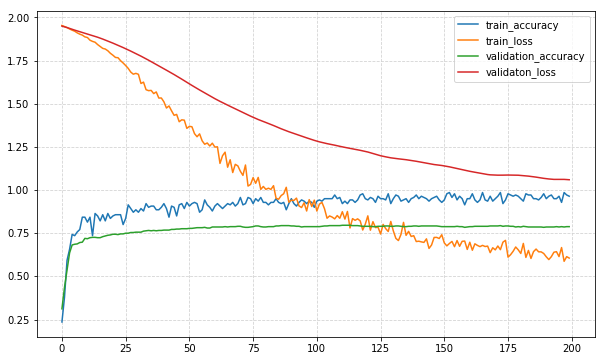

In [26]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 4. Change the input graph/label

Now, create the input graphs using a Stochastic Block Model. The number of nodes should be 500, and then feed the true labels using $20%$ of the nodes. The degree of a node must be used as the feature.
Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps for this input graph.

In [11]:
#--------------- Your code here --------------#





#--------------------------------------------#

In [32]:
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])